# Intro

This strategy follows on from synthetic_long_otm, so it's probably worth looking at that first

In [1]:
import os
import pandas as pd
import numpy as np
import boto3
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [2]:
dynamodb = boto3.resource(
            'dynamodb',
            region_name=os.getenv('AWS_REGION'),
            aws_access_key_id=os.getenv('AWS_ACCESS_KEY'),
            aws_secret_access_key=os.getenv('AWS_SECRET_KEY')
)

table = dynamodb.Table(os.getenv('DYNAMO_TABLE_NAME'))
items = []
resp = table.scan()
items.extend(resp.get('Items', []))
while resp.get('LastEvaluatedKey') is not None:
    resp = table.scan(ExclusiveStartKey=resp['LastEvaluatedKey'])
    items.extend(resp.get('Items', []))
df = pd.DataFrame(items)
df['Date'] = pd.to_datetime(df['Date'])

recent_buys = df[(df['Date'] >= '2025-09-01') & (df['Tx_Type'] == 'Purchase') & (df['Ticker'])]
recent_buys = recent_buys.sort_values(by='Date', ascending=False)
recent_buys.head(5)

,Tx_Type,Comment,Date,Asset_Type,Filer,Owner,Ticker,Amount,id,Asset_Name
1242,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,ISRG,"$50,001 - $100,000",6f923961513c562b495f1069352cdfa5,"Intuitive Surgical, Inc. - Common Stock"
1369,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,UNH,"$15,001 - $50,000",443908ce011136867f61de5665885e88,Unitedhealth Group Inc
1969,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,INTU,"$15,001 - $50,000",47442d16a1d0aa8dcc1e2b0584b34e59,Intuit Inc. - Common Stock
4763,Purchase,None,2025-09-24,Stock,"Mullin, Markwayne",Joint,NOW,"$1,001 - $15,000",79a9c5d7e00284096bb9c6f3c3ec7bd2,"ServiceNow, Inc. Common Stock"
5925,Purchase,None,2025-09-17,Stock,"Boozman, John",Joint,GOOGL,"$15,001 - $50,000",cdbf6c0b009fb9e4a2ffb93e9a54ff0f,Alphabet Cl A


In [3]:
def get_atm_options(ticker_symbol: str, tx_date: pd.Timestamp):
    target_date = tx_date + timedelta(days=90)
    ticker = yf.Ticker(ticker_symbol)
    expirations = [datetime.fromisoformat(date) for date in ticker.options]
    nearest_exp = min(expirations, key=lambda d: abs((d - target_date).days))
    return ticker.option_chain(nearest_exp.strftime('%Y-%m-%d'))

Let's have a look at ISRG in row 1

In [5]:
current_price = yf.Ticker('ISRG').history(period='1d')['Close'][0]
current_price

/tmp/ipykernel_93574/529863589.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  current_price = yf.Ticker('ISRG').history(period='1d')['Close'][0]


np.float64(527.030029296875)

In [6]:
atm_options = get_atm_options('ISRG', pd.Timestamp('2025-09-24'))
atm_calls = atm_options.calls
atm_calls = atm_calls.iloc[(atm_calls['strike'] - current_price).abs().argsort()[:1]]
atm_puts = atm_options.puts
atm_puts = atm_puts.iloc[(atm_puts['strike'] - current_price).abs().argsort()[:1]]

In [7]:
atm_calls

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
40,ISRG251219C00525000,2025-10-22 19:24:03+00:00,525.0,28.9,0.0,0.0,0.0,0.0,31.0,56,0.00001,True,REGULAR,USD


In [8]:
atm_puts

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
45,ISRG251219P00525000,2025-10-22 19:47:40+00:00,525.0,19.9,0.0,0.0,0.0,0.0,47.0,45,0.001963,False,REGULAR,USD


It's technically itm by $2, but we'll go on.

What would a synthetic long position look like:

In [9]:
def get_profit_loss(strike_price, premium_call, premium_put, stock_price):
    S = stock_price
    K = strike_price

    call_payoff = max(0, S - K) - premium_call
    put_payoff = premium_put - max(0, K - S)
    total_payoff = call_payoff + put_payoff
    return total_payoff

In [10]:
pl = []
stock_prices = np.arange(current_price - 50, current_price + 50, 1)
for price in stock_prices:
    profit_loss = get_profit_loss(
        strike_price=atm_calls['strike'].values[0],
        premium_call=atm_calls['lastPrice'].values[0],
        premium_put=atm_puts['lastPrice'].values[0],
        stock_price=price
    )
    pl.append(profit_loss)

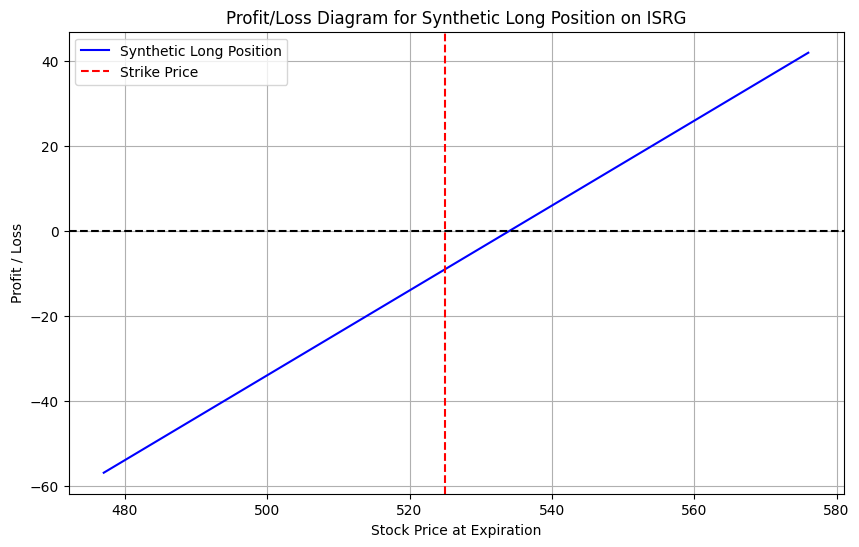

In [11]:
# let's plot the profit/loss diagram
plt.figure(figsize=(10,6))
plt.plot(stock_prices, pl, label='Synthetic Long Position', color='blue')
plt.axhline(0, color='black', linestyle='--')
plt.axvline(atm_calls['strike'].values[0], color='red', linestyle='--', label='Strike Price')
plt.title('Profit/Loss Diagram for Synthetic Long Position on ISRG')
plt.xlabel('Stock Price at Expiration')
plt.ylabel('Profit / Loss')
plt.legend()
plt.grid()
plt.show()

In [12]:
# Let's calculate breakeven point
strike_price = atm_calls['strike'].values[0]
premium_call = atm_calls['lastPrice'].values[0]
premium_put = atm_puts['lastPrice'].values[0]
breakeven_price = strike_price + (premium_call - premium_put)
breakeven_price

np.float64(534.0)

# Conclusion

The position starts to make money after 1.3% appreciation (excluding broker fees)